In [183]:
import pandas as pd
import ppscore as pps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency


In [184]:
depression_df = pd.read_csv("data.tsv", sep="\t", header=0)

### Choose Relevant Columns

In [185]:
def adyo(cols):
    return np.array([[f"{p}{b}" for b in cols] for p in ["AD", "YO"]]).ravel().tolist()

In [186]:
indicator_col = "DEPRESSIONINDEX"
age_col = ["CATAG2", "CATAG3", "CATAG7"][0]

cols_dict = {
    "cat_bin": adyo(
        [
            "_MDEA1",
            "_MDEA2",
            "_MDEA3",
            "_MDEA4",
            "_MDEA5",
            "_MDEA6",
            "_MDEA7",
            "_MDEA9",
            "WRDBTR",
            "WRTHOT",
            "WRNOGD",
            "WRDCSN",
            "WRCONC",
            "WRENRG",
            "WRWRTH",
            "WRPROB",
            "WRDLOT",
            "WRSTHK",
            "WRSLEP",
            "WRELES",
            "WRSATP",
            "WRSPLN",
            "WRJINO",
            "WRJITT",
            "WRSLNO",
            "WRSMOR",
            "WRLSL2",
            "WRDIET",
            "WRLOSE",
            "WRGNL2",
            "WRPREG",
            "WRGROW",
            "WRGAIN",
            "WREMOR",
            "WRPLSR",
            "WRLSIN",
            "WRDISC",
            "WRDEPR",
        ]
    )
    + [
        "MJANDCOKE",
        "ILLICITDRUGUSE",
        "LSYRILLICIT",
        "COKECRACK",
        "OTHERILLICIT",
        "MJCOKELY",
        "COCCRKLY",
        "MJGT12MO",
        "COCGT12MO",
        "ANYGT12MO",
        "IRPRVHLT",
        "WORKFORCE",
        "CRIMEHIST",
        "ANYSDRUG",
        "ANYATTACK",
        "ANYTHEFT",
        "TXLCAD",
        "RKIDSHH",
        "MARRIED",
        "CHILDRENINHOME",
        "IRSEX",
    ],
    "cat_nom": ["NEWRACE2", "ALCFMFPB", "EMPSTAT4", "CACHAR", "CATYPE", "IRMARIT"],
    "cat_ord": adyo(
        [
            "WRHRS",
            "WRDST",
            "WRCHR",
            "WRIMP",
        ]
    )
    + [
        "ANYINDEX",
        "IREDUC2",
        "INCOME",
        "INCOME_R",
        "POVERTY",
        "REVERSEPOP",
        "MOVESPY2",
        "NUMARREST",
        "HEALTH2",
        "NOMARR2",
        "DSTNCALM",
        "DSTTIRE",
        "DSTSITST",
        "DSTDEPRS",
        "DSTCHEER",
        "DSTNRVOS",
        age_col,
        indicator_col,
    ],
    "num_dis": adyo(
        [
            "WRAGE",
        ]
    )
    + ["SCHDSICK"],
    "num_con": [],
}

In [187]:
depression_df = depression_df[[col for cols in cols_dict.values() for col in cols]]

### Swap Non-Available Custom Values to nan

In [188]:
def swap_to_nan(df, cols, range):
    df = df.copy()
    lr, ur = range
    df[cols] = df[cols].where((df[cols] >= lr) & (df[cols] <= ur), np.nan)
    return df


depression_df = depression_df[depression_df[indicator_col] != -9]
depression_df.reset_index(drop=True, inplace=True)

range_dict = {
    "cat_bin": (0, 2),
    "cat_ord": (0, 20),
    "cat_nom": (0, 93),
    "num_dis": (0, 30),
    "num_con": (0, 0),
}

for col_type, cols in cols_dict.items():
    depression_df = swap_to_nan(depression_df, cols, range_dict[col_type])

### Merge AD and YO Columns

In [189]:
for yo_col in depression_df.columns:
    if "YO" in yo_col:
        postfix = yo_col.split("YO")[1]
        ad_col = f"AD{postfix}"
        new_col = f"&{postfix}"
        if ad_col in depression_df.columns:
            depression_df[yo_col].fillna(depression_df[ad_col], inplace=True)
            depression_df.rename(columns={yo_col: new_col}, inplace=True)
            depression_df.drop(columns=[ad_col], inplace=True)

            for col_type, cols in cols_dict.items():
                if yo_col in cols:
                    cols[cols.index(yo_col)] = new_col
                    cols.remove(ad_col)

### Add Somatic Depression Column and append it to cols_dict

In [190]:
symptoms_cols = [
    "&_MDEA3",  # apetite
    "&_MDEA4",  # sleep
    "&_MDEA6",  # fatigue
    indicator_col,
]
if all(symptom in depression_df.columns for symptom in symptoms_cols):
    som_dep_df = depression_df[symptoms_cols].copy()
    som_dep_df["DEPRESSION"] = np.where(som_dep_df[indicator_col] > 0, 1, 2)
    som_dep_df.drop(columns=indicator_col, inplace=True)

    som_dep_no = som_dep_df.eq(2).any(axis=1)
    som_dep_yes = som_dep_df.eq(1).all(axis=1)

    depression_df["SOMATICDEP"] = np.nan
    depression_df.loc[som_dep_no, "SOMATICDEP"] = 0
    depression_df.loc[som_dep_yes, "SOMATICDEP"] = 1

    cols_dict["cat_bin"].append("SOMATICDEP")
else:
    print("Not all symptoms columns are present")

### Drop columns that are all nan and filter out these names from the column lists

In [191]:
original_cols = depression_df.columns.tolist()
depression_df.dropna(axis=1, how="all", inplace=True)
remaining_cols = depression_df.columns.tolist()
dropped_cols = list(set(original_cols) - set(remaining_cols))

for key, value in cols_dict.items():
    cols_dict[key] = list(set(value) & set(remaining_cols))
    
print(f"Dropped empty columns: {dropped_cols}")

Dropped empty columns: ['DSTNCALM', 'DSTTIRE', 'DSTSITST', 'DSTDEPRS']


### Drop columns that were probably used to create DEPRESSIONINDEX

In [192]:
filter_out = ["&", "DST"]

depression_df.drop(columns=[col for col in depression_df.columns if any(f in col for f in filter_out)], inplace=True)

for key, value in cols_dict.items():
    cols_dict[key] = [col for col in value if not any(f in col for f in filter_out)]

### Drop col if more than 50% of the values are nan

<Axes: xlabel='None', ylabel='None'>

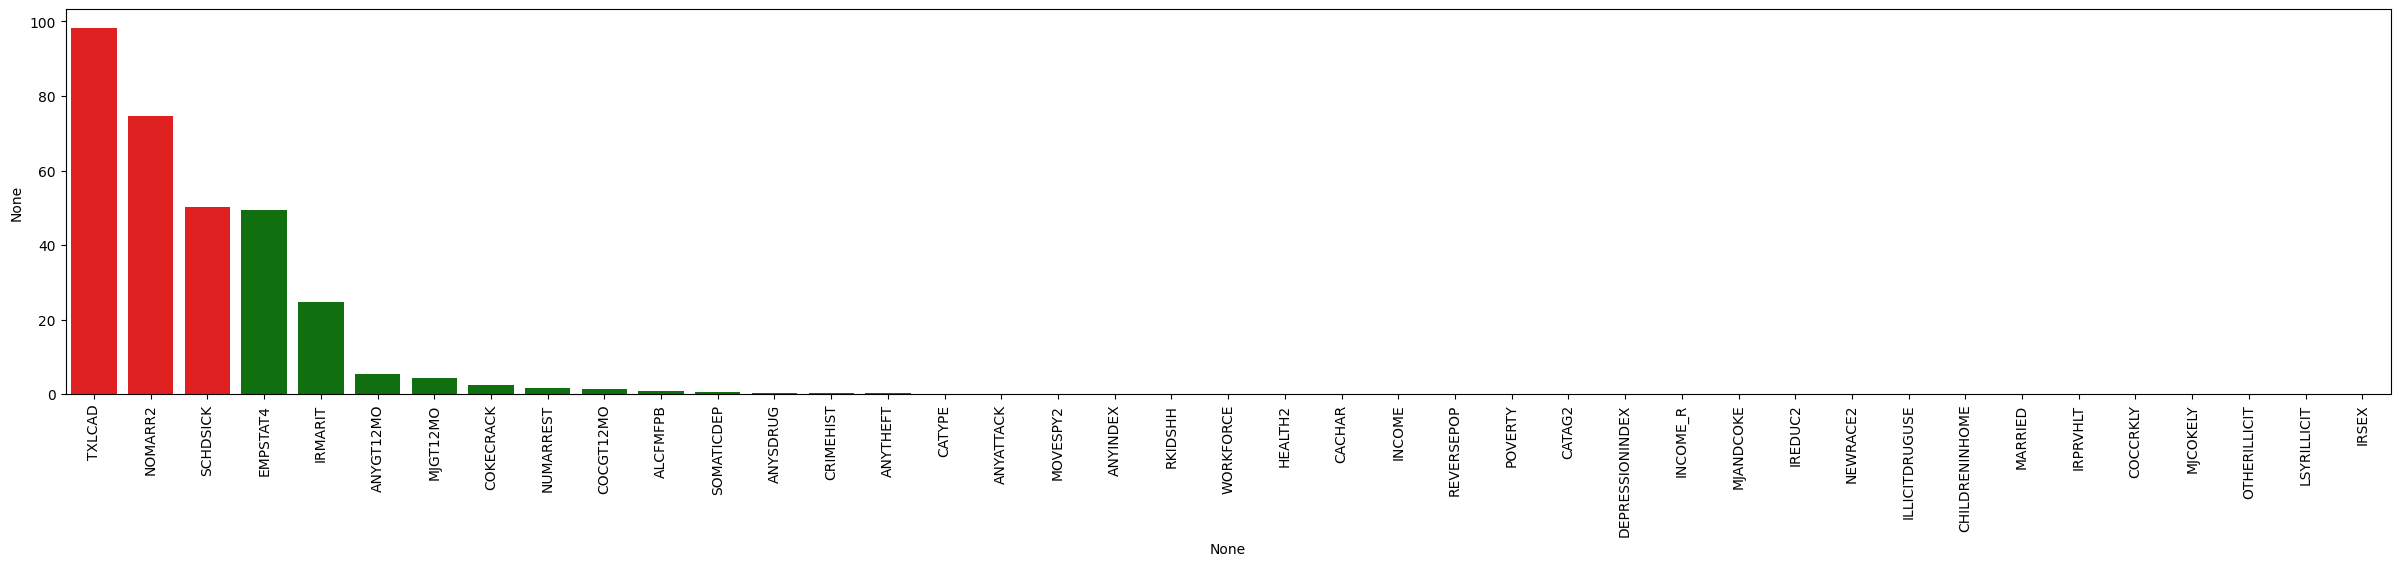

In [193]:
PERCENTAGE_THRESHOLD = 50
stats = (
    depression_df.isnull().sum().sort_values(ascending=False)
    / depression_df.shape[0]
    * 100
)
depression_df = depression_df[stats[stats < PERCENTAGE_THRESHOLD].index]
for key, value in cols_dict.items():
    cols_dict[key] = [col for col in value if col in depression_df.columns]

colors = ["green" if value < PERCENTAGE_THRESHOLD else "red" for value in stats]
plt.figure(figsize=(30, 5))
plt.xticks(rotation=90)
sns.barplot(y=stats, x=stats.index, palette=colors, hue=stats.index)

### Preliminary Analysis
Find N significantly different factors influencing the depression level.

In [194]:
def get_pearson(df):
    return df.corr("pearson")


def get_spearman(df):
    return df.corr("spearman")


def get_pps(df, col):
    return pps.predictors(df, col)[["x", "ppscore"]]


def get_chi2(df, col):
    results = []
    for var_col in set(df.columns.tolist()) - set([col]):
        contingency_table = pd.crosstab(df[col], df[var_col])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        results.append(
            {
                "Variable": var_col,
                "Chi2": chi2,
                "P": p,
                "Dof": dof,
                "Expected": expected,
                "Chi2/DoF": chi2 / dof,
            }
        )
    results_df = pd.DataFrame(results)
    return results_df


def analyse(
    df,
    cols_dict,
    indicator_col,
):
    categorical_cols = (
        cols_dict["cat_bin"] + cols_dict["cat_nom"] + cols_dict["cat_ord"]
    )
    numerical_cols = cols_dict["num_dis"] + cols_dict["num_con"]

    pearson_df = get_pearson(df[cols_dict["cat_ord"] + numerical_cols])
    spearman_df = get_spearman(df[cols_dict["cat_ord"] + numerical_cols])

    pps_depression_df = pd.concat(
        [
            depression_df[categorical_cols].astype(str),
            depression_df[numerical_cols],
        ],
        axis=1,
    )

    pps_df = get_pps(pps_depression_df, indicator_col)

    chi2_df = get_chi2(
        df[cols_dict["cat_bin"] + cols_dict["cat_nom"] + cols_dict["cat_ord"]],
        indicator_col,
    )

    return pearson_df, spearman_df, pps_df, chi2_df

In [195]:
pearson_df, spearman_df, pps_df, chi2_df = analyse(
    df=depression_df,
    cols_dict=cols_dict,
    indicator_col=indicator_col,
)

<Axes: >

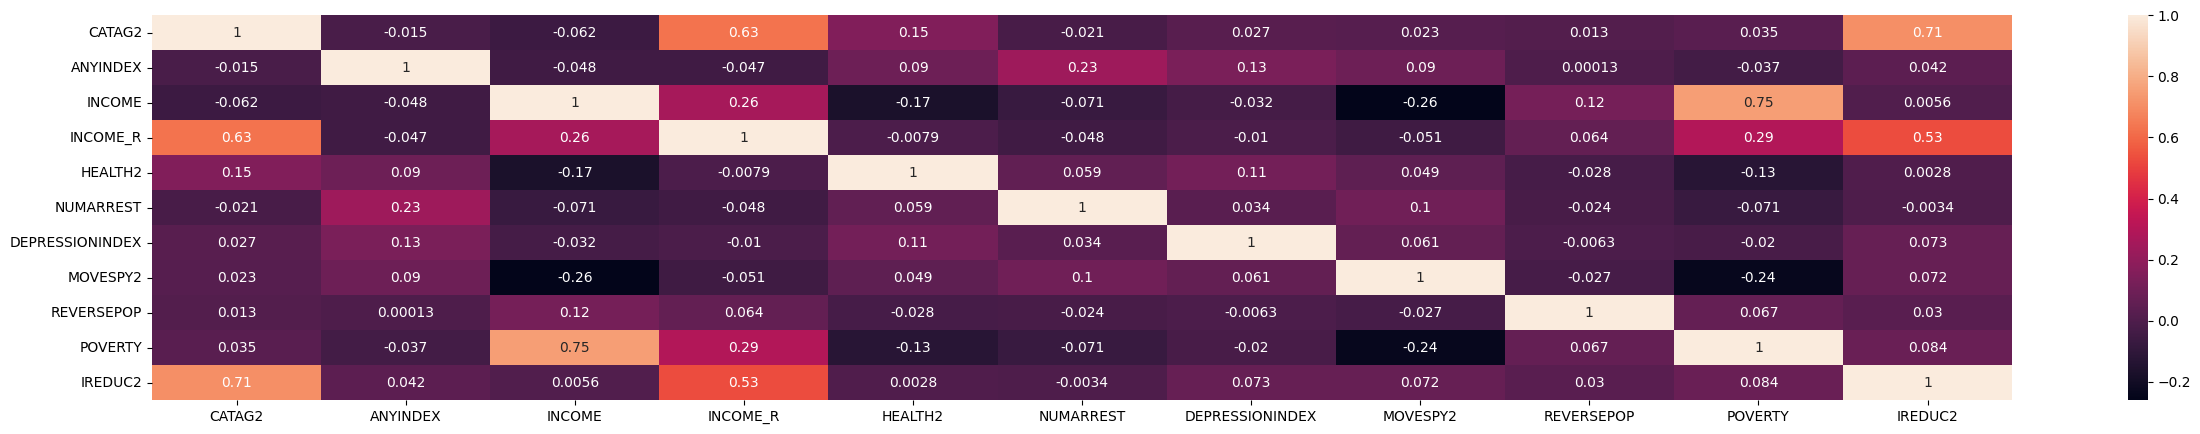

In [196]:
plt.figure(figsize=(30, 5))
sns.heatmap(pearson_df, annot=True)

<Axes: >

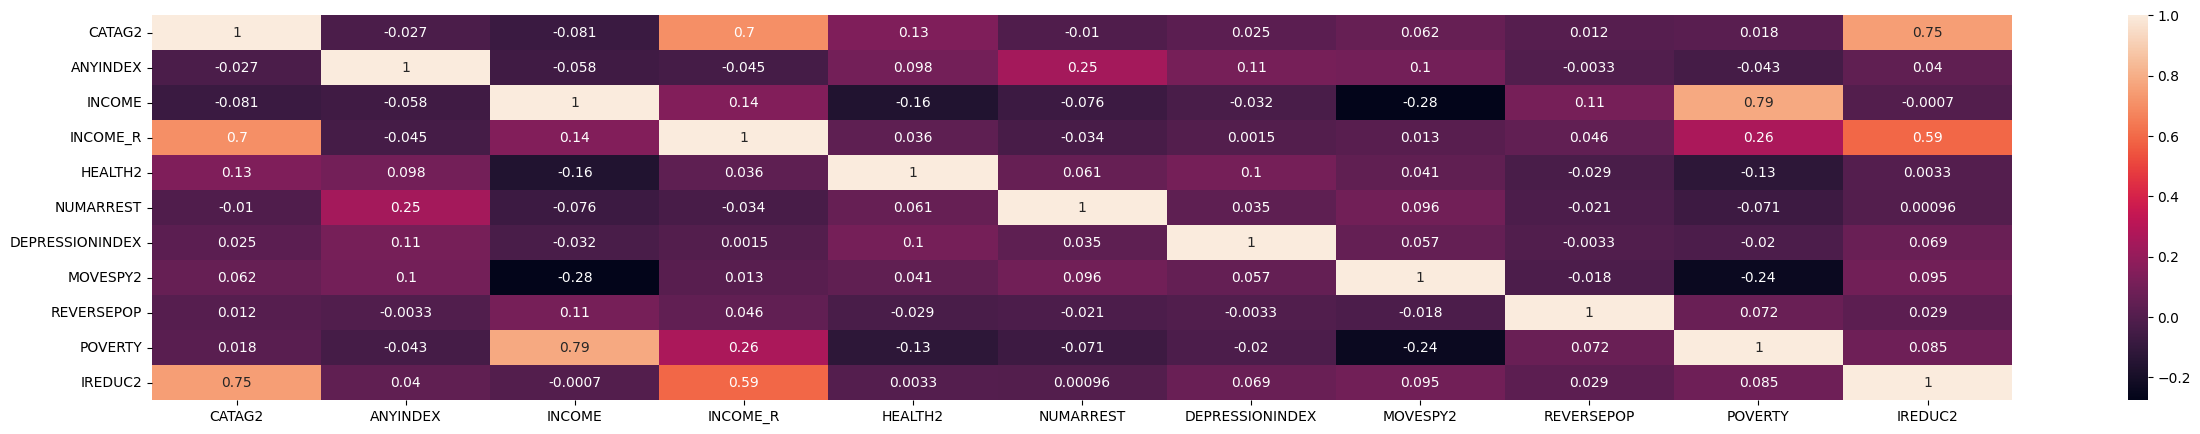

In [197]:
plt.figure(figsize=(30, 5))
sns.heatmap(spearman_df, annot=True)

<Axes: xlabel='x', ylabel='ppscore'>

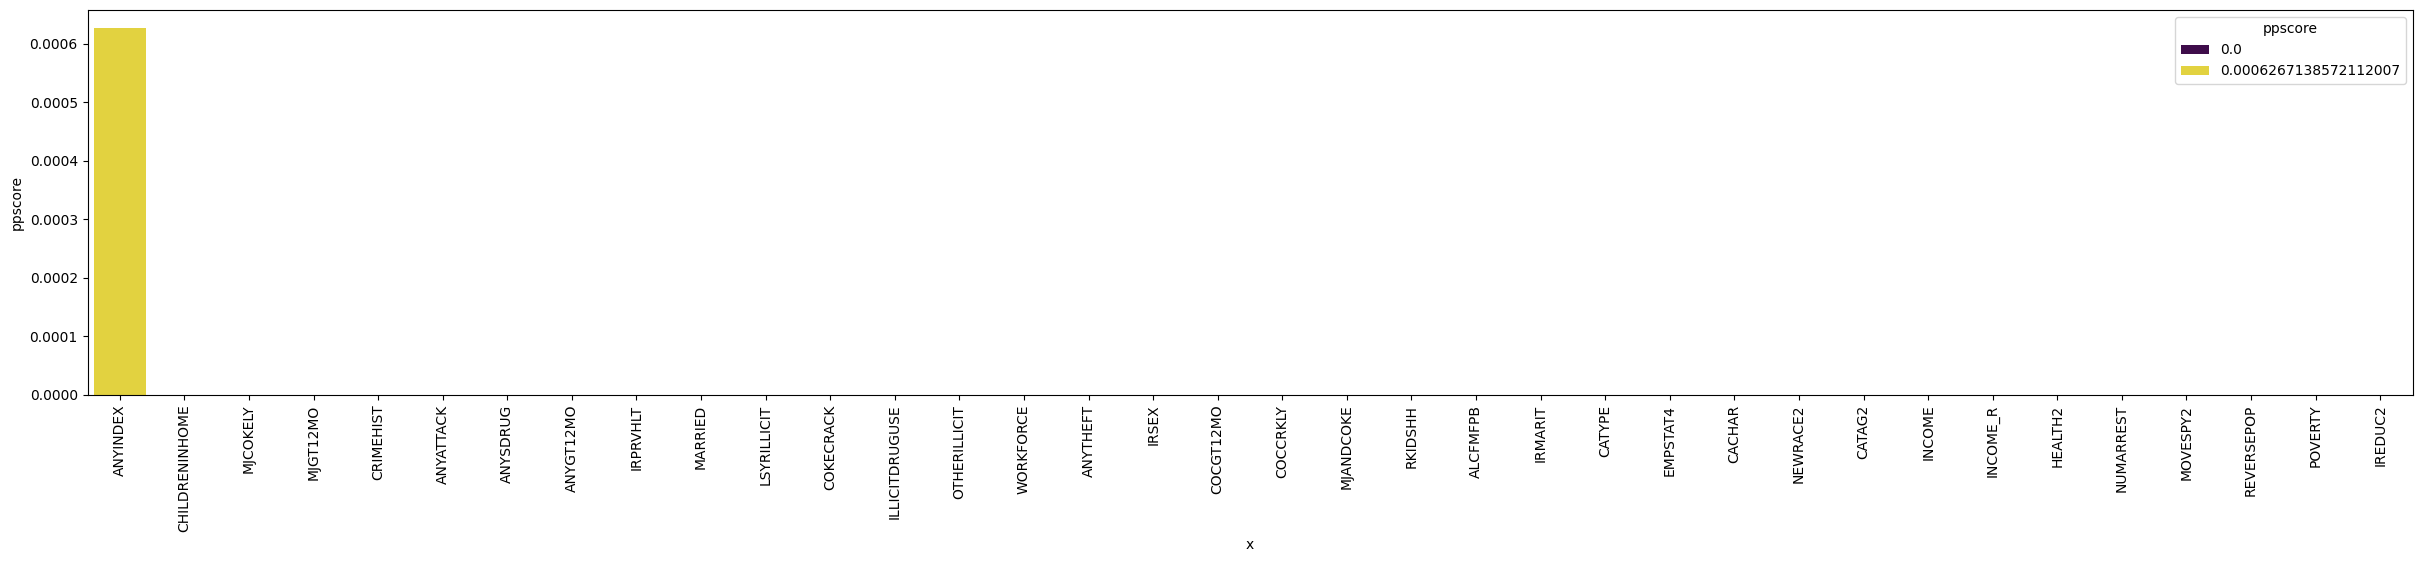

In [198]:
pps_df = pps_df[pps_df['x'] != 'SOMATICDEP']

plt.figure(figsize=(30, 5))
plt.xticks(rotation=90)
sns.barplot(y="ppscore", x="x", data=pps_df, palette="viridis", hue="ppscore")

<Axes: xlabel='Variable', ylabel='Chi2/DoF'>

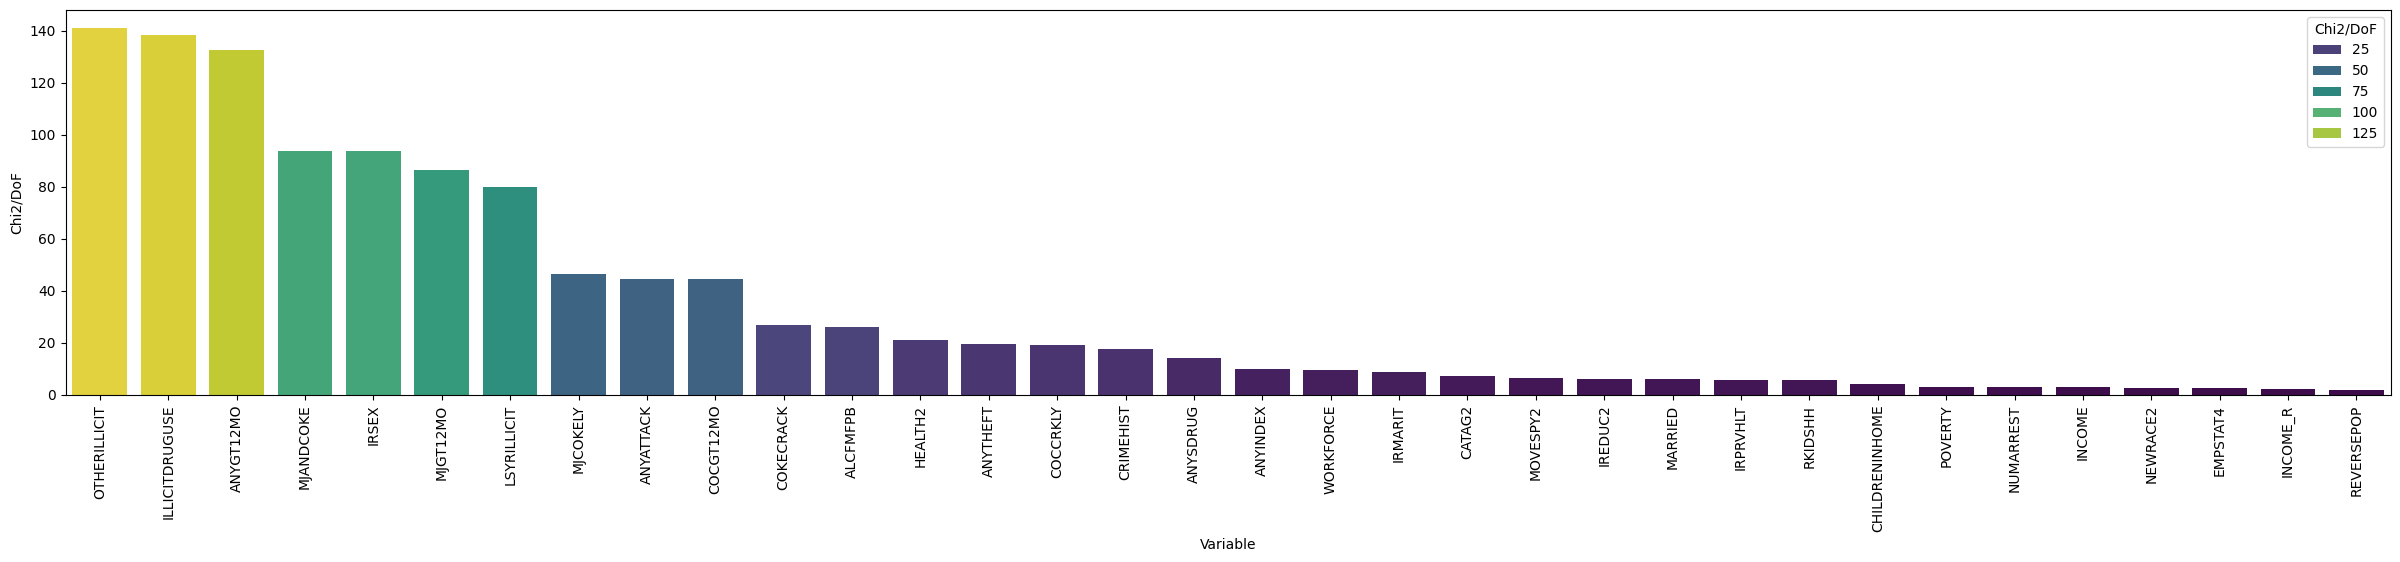

In [199]:
chi2_df = chi2_df[chi2_df['Variable'] != 'SOMATICDEP']

chi2_df = chi2_df[chi2_df["P"] < 0.05]
chi2_df = chi2_df.sort_values(by="Chi2/DoF", ascending=False).reset_index(drop=True)

plt.figure(figsize=(30, 5))
plt.xticks(rotation=90)
sns.barplot(y="Chi2/DoF", x="Variable", data=chi2_df, palette="viridis", hue="Chi2/DoF")

### Choose N most significant features

In [200]:
N = 20
potential_features = chi2_df["Variable"][:N].to_list()
potential_features

['OTHERILLICIT',
 'ILLICITDRUGUSE',
 'ANYGT12MO',
 'MJANDCOKE',
 'IRSEX',
 'MJGT12MO',
 'LSYRILLICIT',
 'MJCOKELY',
 'ANYATTACK',
 'COCGT12MO',
 'COKECRACK',
 'ALCFMFPB',
 'HEALTH2',
 'ANYTHEFT',
 'COCCRKLY',
 'CRIMEHIST',
 'ANYSDRUG',
 'ANYINDEX',
 'WORKFORCE',
 'IRMARIT']

In [201]:
# TODO: Add filtering from potential features??
features = ["ILLICITDRUGUSE", "ANYATTACK", "ALCFMFPB", "HEALTH2", "CRIMEHIST", "WORKFORCE"]

### Analysis Performed For Different Groups

In [202]:
groups = ["IRSEX", "SOMATICDEP", age_col]
features_df = depression_df[features + groups + [indicator_col]]

In [203]:
def get_chi2_col(df, col, ignore):
    df = df.dropna(subset=[col])
    split_dfs = {category: df[df[col] == category] for category in df[col].unique()}
    analysis = []
    for category, split_df in split_dfs.items():
        chi2_df = get_chi2(
            split_df.drop(columns=ignore),
            indicator_col,
        )
        chi2_df[col] = category
        analysis.append(chi2_df)
    return pd.concat(analysis)


def plot_chi2_col(df, col, ignore):
    plt.figure(figsize=(10, 5))
    sns.barplot(
        y="Chi2/DoF",
        x="Variable",
        data=get_chi2_col(df, col, ignore),
        hue=col,
    )

#### Gender

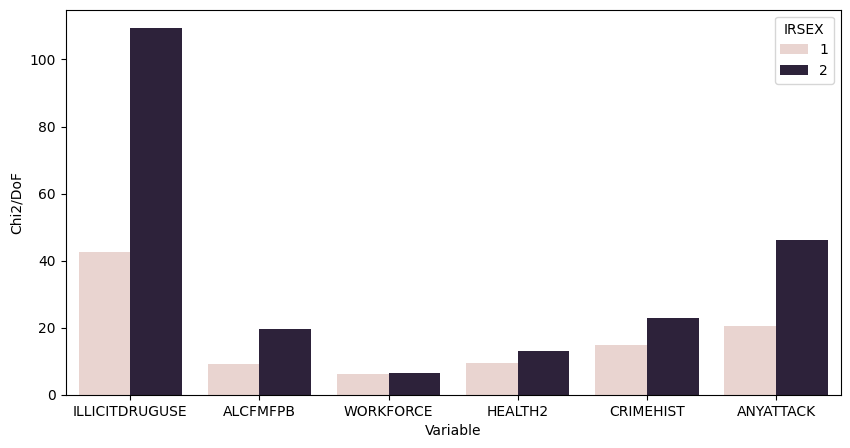

In [204]:
plot_chi2_col(features_df, "IRSEX", groups)

#### Age

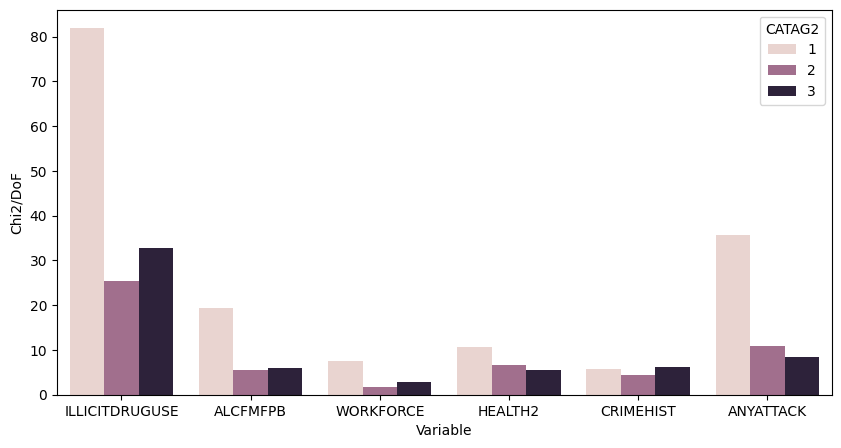

In [205]:
plot_chi2_col(features_df, age_col, groups)

#### Depression Type

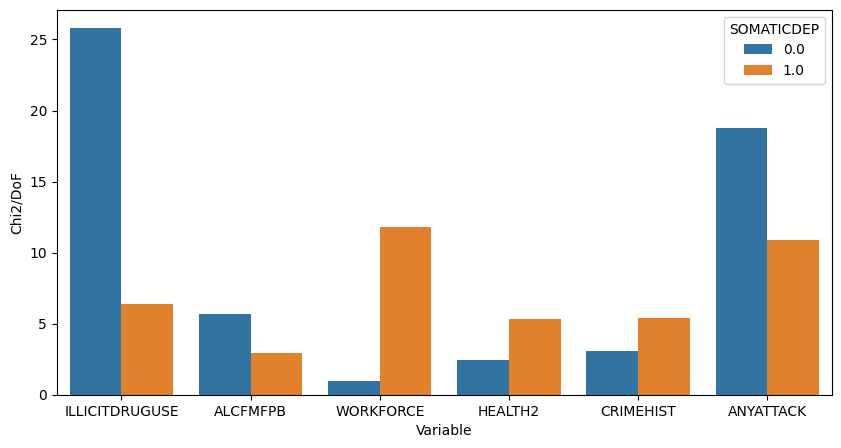

In [206]:
plot_chi2_col(features_df, "SOMATICDEP", groups)